In [1]:
! pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip /content/drive/MyDrive/Assignment4/train.csv.zip

Archive:  /content/drive/MyDrive/Assignment4/train.csv.zip
  inflating: train.csv               


In [4]:
! unzip /content/drive/MyDrive/Assignment4/test.csv.zip

Archive:  /content/drive/MyDrive/Assignment4/test.csv.zip
  inflating: test.csv                


In [5]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [6]:
df = pd.read_csv('/content/train.csv')

def process_pixels(pixel_str):
    pixels = np.fromstring(pixel_str, sep=' ', dtype=np.uint8)
    return pixels.reshape(48, 48)

images = np.array([process_pixels(p) for p in df['pixels']])
labels = df['emotion'].values

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Images shape: (28709, 48, 48)
Labels shape: (28709,)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=7, stratify=labels)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=7, stratify=y_temp)

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray(image.astype(np.uint8), mode='L')
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
train_dataset = CustomImageDataset(X_train, y_train, transform=transform)
val_dataset = CustomImageDataset(X_val, y_val, transform=transform)
test_dataset = CustomImageDataset(X_test, y_test, transform=transform)

In [46]:
LR = 1e-4
BATCH_SIZE = 62
EPOCHS = 10

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

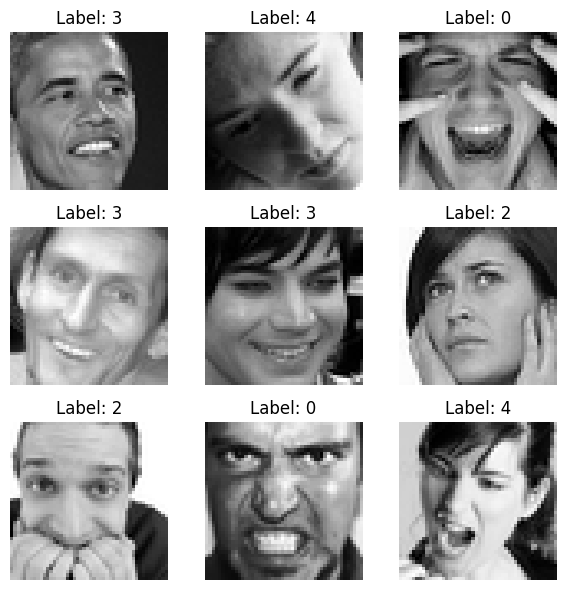

In [13]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols, figsize=(6, 6))

for row in range(n_rows):
    for col in range(n_cols):
        idx = np.random.randint(len(X_train))
        image = X_train[idx]
        label = y_train[idx]

        axarr[row, col].imshow(image, cmap='gray')
        axarr[row, col].set_title(f"Label: {label}")
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [47]:
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 256),
            nn.ReLU(),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        return self.net(x)


In [48]:
model = DeepCNN().to(device)
model = model.to(device)

In [49]:
from torchsummary import summary
summary(model, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
            Conv2d-3           [-1, 64, 48, 48]          18,496
              ReLU-4           [-1, 64, 48, 48]               0
         MaxPool2d-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 128, 24, 24]          73,856
              ReLU-7          [-1, 128, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]         147,584
              ReLU-9          [-1, 128, 24, 24]               0
        MaxPool2d-10          [-1, 128, 12, 12]               0
          Flatten-11                [-1, 18432]               0
           Linear-12                  [-1, 256]       4,718,848
             ReLU-13                  [-1, 256]               0
           Linear-14                   

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=1e-5)

In [24]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        train_loss.backward()
        optimizer.step()

        train_acc = (outputs.argmax(1) == labels).sum().item()
        total_acc_train += train_acc

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (outputs.argmax(1) == labels).sum().item()
            total_acc_val += val_acc

    train_size = len(train_dataset)
    val_size = len(val_dataset)

    total_loss_train_plot.append(round(total_loss_train / len(train_loader), 4))
    total_loss_validation_plot.append(round(total_loss_val / len(val_loader), 4))
    total_acc_train_plot.append(round(total_acc_train / train_size * 100, 2))
    total_acc_validation_plot.append(round(total_acc_val / val_size * 100, 2))

    print(f'''Epoch {epoch+1}/{EPOCHS}
    Train Loss: {round(total_loss_train / len(train_loader), 4)} | Train Accuracy: {round(total_acc_train / train_size * 100, 2)}%
    Val Loss: {round(total_loss_val / len(val_loader), 4)} | Val Accuracy: {round(total_acc_val / val_size * 100, 2)}%''')
    print("="*30)


Epoch 1/10
    Train Loss: 1.664 | Train Accuracy: 34.06%
    Val Loss: 1.5412 | Val Accuracy: 41.06%
Epoch 2/10
    Train Loss: 1.4525 | Train Accuracy: 44.44%
    Val Loss: 1.4178 | Val Accuracy: 45.61%
Epoch 3/10
    Train Loss: 1.3185 | Train Accuracy: 49.81%
    Val Loss: 1.3435 | Val Accuracy: 49.3%
Epoch 4/10
    Train Loss: 1.2026 | Train Accuracy: 54.69%
    Val Loss: 1.3025 | Val Accuracy: 50.49%
Epoch 5/10
    Train Loss: 1.0885 | Train Accuracy: 59.78%
    Val Loss: 1.3073 | Val Accuracy: 51.51%
Epoch 6/10
    Train Loss: 0.9584 | Train Accuracy: 64.92%
    Val Loss: 1.3112 | Val Accuracy: 52.46%
Epoch 7/10
    Train Loss: 0.8103 | Train Accuracy: 71.05%
    Val Loss: 1.3834 | Val Accuracy: 53.11%
Epoch 8/10
    Train Loss: 0.6296 | Train Accuracy: 77.88%
    Val Loss: 1.5197 | Val Accuracy: 52.95%
Epoch 9/10
    Train Loss: 0.4416 | Train Accuracy: 85.17%
    Val Loss: 1.67 | Val Accuracy: 52.86%
Epoch 10/10
    Train Loss: 0.2788 | Train Accuracy: 91.18%
    Val Loss: 1.9

In [19]:
with torch.no_grad():
    model.eval()
    total_loss_test = 0
    total_acc_test = 0

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        predictions = model(inputs)

        acc = (predictions.argmax(1) == labels).sum().item()
        total_acc_test += acc

        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

test_size = len(test_dataset)
average_loss = round(total_loss_test / len(test_loader), 4)
accuracy = round((total_acc_test / test_size) * 100, 2)

print(f"Test Accuracy: {accuracy}%")
print(f"Test Loss: {average_loss}")


Test Accuracy: 51.59%
Test Loss: 3.0694


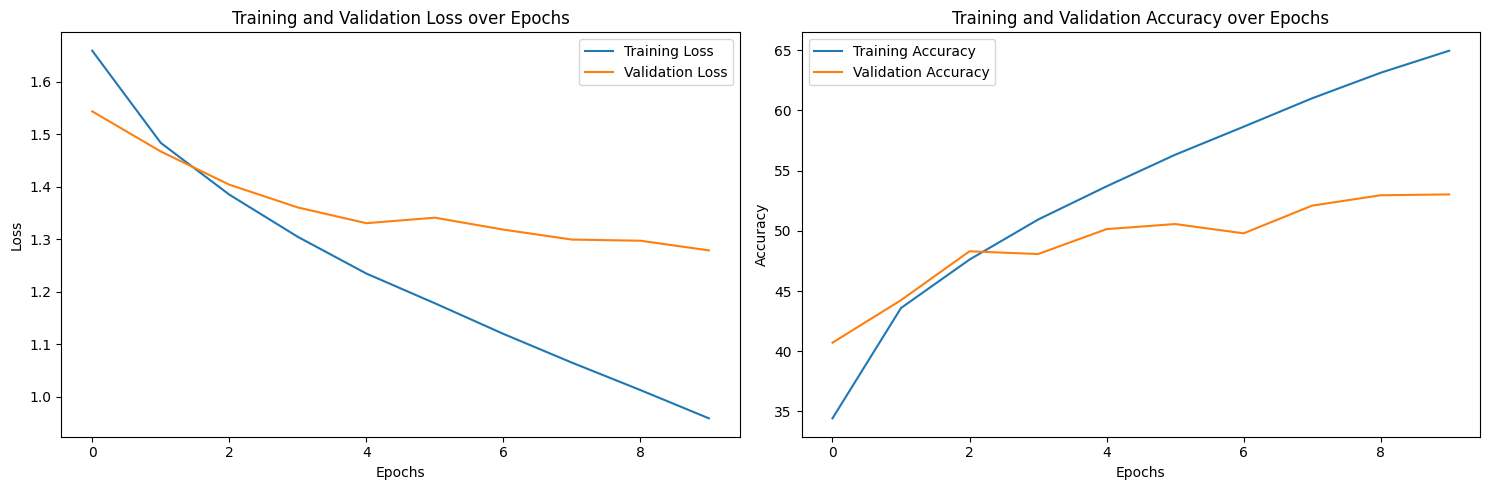

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

In [31]:
!pip install wandb
import wandb

In [32]:
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gbend22 (gbend22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [51]:
wandb.init(
    project="ml-homework-4",
    group="deep-cnn",
    name="higher-epochs",
    config={
        "learning_rate": LR,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "architecture": "CustomCNN"
    }
)


for epoch in range(EPOCHS):
    model.train()
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        total_acc_train += (outputs.argmax(1) == labels).sum().item()

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            total_acc_val += (outputs.argmax(1) == labels).sum().item()

    train_acc = total_acc_train / len(train_dataset)
    val_acc = total_acc_val / len(val_dataset)
    train_loss = total_loss_train / len(train_loader)
    val_loss = total_loss_val / len(val_loader)

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc
    })

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

torch.save(model.state_dict(), "model.pth")
wandb.save("model.pth")
wandb.finish()

Epoch 1: Train Loss = 1.6522, Val Loss = 1.5497, Train Acc = 0.3493, Val Acc = 0.3922
Epoch 2: Train Loss = 1.4416, Val Loss = 1.4209, Train Acc = 0.4476, Val Acc = 0.4568
Epoch 3: Train Loss = 1.3093, Val Loss = 1.3600, Train Acc = 0.5029, Val Acc = 0.4837
Epoch 4: Train Loss = 1.1957, Val Loss = 1.3158, Train Acc = 0.5491, Val Acc = 0.4944
Epoch 5: Train Loss = 1.0829, Val Loss = 1.3266, Train Acc = 0.5973, Val Acc = 0.5165
Epoch 6: Train Loss = 0.9584, Val Loss = 1.3197, Train Acc = 0.6485, Val Acc = 0.5149
Epoch 7: Train Loss = 0.8105, Val Loss = 1.3517, Train Acc = 0.7104, Val Acc = 0.5353
Epoch 8: Train Loss = 0.6406, Val Loss = 1.5231, Train Acc = 0.7763, Val Acc = 0.5246
Epoch 9: Train Loss = 0.4616, Val Loss = 1.7171, Train Acc = 0.8416, Val Acc = 0.5197
Epoch 10: Train Loss = 0.2999, Val Loss = 1.8997, Train Acc = 0.9030, Val Acc = 0.5360
Epoch 11: Train Loss = 0.1821, Val Loss = 2.2958, Train Acc = 0.9447, Val Acc = 0.5300
Epoch 12: Train Loss = 0.1214, Val Loss = 2.7984, Tr

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▃▄▄▅▆▆▇██████████
train_loss,█▇▇▆▆▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇█▇▇██▇▇██████▇
val_loss,▂▁▁▁▁▁▁▂▂▃▄▆▆▇▇▇▇▇██
epoch,20
train_accuracy,0.9896
train_loss,0.05019
val_accuracy,0.52369
val_loss,3.35515
